# Assignment 3 - Tumor segmentation with uncertainties

### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

For radiotherapy treatment, often multiple contrasts are acquired of the same anatomy to have more information for organ delineations. These contrasts have been explored in the previous assignment, and now, your task is to automate the organ delineation! The model to design and train might take any number of image contrasts as an input, and outputs a tumor segmentation. For this task, you will implement and use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate (aim for a Dice score higher than $0.8$ on the validation set).

For machine learning solutions to be reliable in real life scenarios, we may want to improve their explainability. Ideally, models should not only provide their predictions, but provide a motivation for them as well. One form of explainability is through uncertainty metrics, that evaluate how certain layers, and certain nodes affect the output predictions. A popular approach is called *Monte Carlo Dropout*, where during inference, output predictions are generated multiple times using differently initialized dropout layers, therefore the individual predictions will depend on different subsets of the layers' activations. The standard deviation in the generated outputs provides insight into the model's uncertainty about the individual pixels of the predictions, in our case, the segmentations.

Your task is to look through the highly customizable code below, which contains all the main steps for automated image segmentation from using only one contrast as an input. By changing the arrays of the DataGenerator, multiple contrasts can be added as input, similar as in the previous assignmnets. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the report, are:
- How you reached the required performances (a Dice score above $0.8$)
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Once you have reached the required loss on the validation data, only then evaluate your model on the testing data as well.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.
- Using the already implemented Monte Carlo Dropout model, explore the uncertainty of the predictions on the testing data.
- How does your estimated uncertainty depend on the dropout-rates used in the model?
- Look at the uncertainty of each image in the testing dataset. Do you see anything unusual in their values? If so explore the images!

Upload the updated notebook to Canvas by June $2^{nd}$ at 17:00.

Good luck and have fun!

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
random.seed(2023)

import numpy as np
np.random.seed(2023)  # Set seed for reproducibility

import tensorflow as tf
tf.random.set_seed(2023)

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

from scipy.ndimage import zoom
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [2]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                im = zoom(im, 0.25)
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    if (np.max(x) > 0):
                        x /= np.max(x)
                    x = zoom(x, 0.25)
                    if (self.arrays[idx] == "mask"):
                        x = x > 0.5
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!
# NOTE: There is now a resizing part of the images, this is to make training easier and faster.

In [3]:
gen_dir = "./data/" #/import/software/3ra023/vt23/brats/data/" # Change if you have copied the data locally on your machine 
array_labels = ['t1', 't1ce', 't2', 'flair', 'mask']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
batch_size = 16

class DataGeneratorStacked(DataGenerator):
    """
    Wrapper for the DataGenerator that stacks the inputs.
    """
    def __getitem__(self, index):
        *inputs, mask = super().__getitem__(index)
        inputs = np.concatenate(inputs, axis=-1)
        return inputs, mask


gen_train = DataGeneratorStacked(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGeneratorStacked(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGeneratorStacked(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? You can use multiple contrasts as inputs, if you'd like. (STRONGLY encouraged)
# NOTE: What batch size are you using? Should you use more? Or less? What are the pros and cons?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

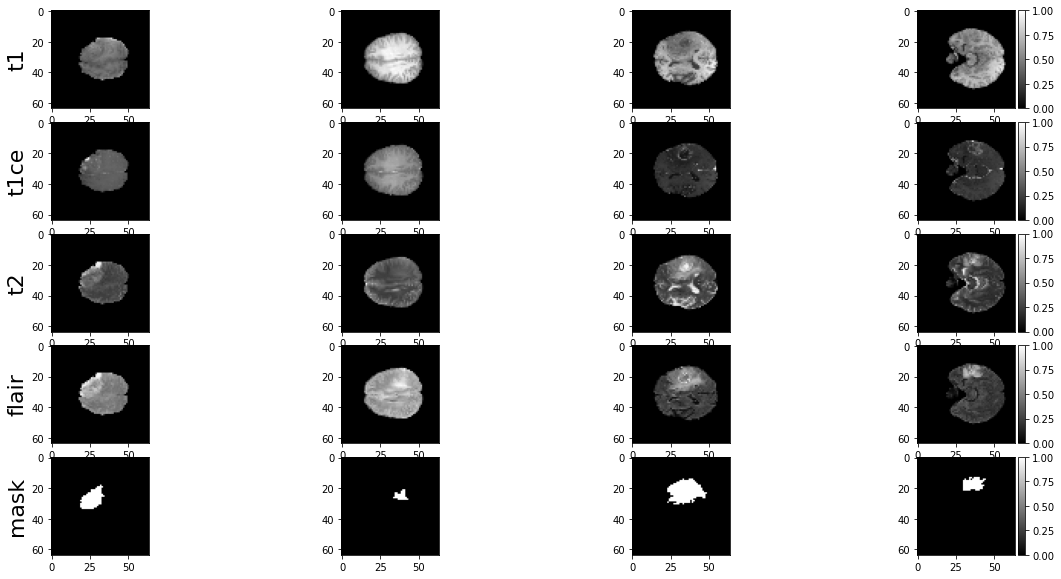

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16.0, 8.0))
fig.subplots_adjust(left=0.001,
                    right=0.9975,
                    top=0.95,
                    bottom=0.005,
                    wspace=0.05,
                    hspace=0.14)

M, N = len(gen_train.arrays), 4
ax = []
for i in range(M):
    ax.append([None] * N)
    for j in range(N):
        ax[i][j] = plt.subplot2grid((M, N), (i, j), rowspan=1, colspan=1)

imgs, mask = gen_train[0]
imgs = np.concatenate([imgs,mask], axis=-1)
idx = np.random.randint(0, np.shape(gen_train[0][0])[0], 5)
ii = 0
for j in range(N):
    for i in range(M):
        im = ax[i][j].imshow(imgs[idx[ii], :, :, i], cmap='gray', vmin=0, vmax=1)

        if j == 0:  # Label only on the left
            ax[i][j].set_ylabel(gen_train.arrays[i], fontsize=22)
        if j == N - 1:  # Colorbar only on the right
            divider = make_axes_locatable(ax[i][j])
            cax1 = divider.append_axes("right", size="7%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax1)
    ii += 1    

### There's a chance, that the bottom row only shows black images, in that case, all four examples are from slices that don't have masks.

A quick summary of the data:

In [5]:
# A quick summary of the data:

print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")
found_masks = 0
for idx, (inputs, mask) in enumerate(gen_val): # Add the additional inputs inside the brackets
    found_masks += np.sum(np.sum(mask > 0, (1, 2, 3)) > 0)
print(f"The percentage of slices that contain masks : {np.round(100 * (found_masks / (len(gen_val) * batch_size)), 2)}%")

Number of training images : 8000
Training batch size       : [(16, 64, 64, 1), (16, 64, 64, 1), (16, 64, 64, 1), (16, 64, 64, 1), (16, 64, 64, 1)]


/tmp/ipykernel_11578/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


The percentage of slices that contain masks : 67.54%


### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

In [6]:
# Import packages important for building and training your model.

import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from IPython.display import clear_output
%matplotlib inline

In [7]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose, Concatenate, LeakyReLU
from tensorflow.keras.models import Model
 
def build_generator(in_shape=(64, 64, 1),num_filt=4, dropout_rate=0.1):
    inputs = Input(in_shape)
    activation = "selu"
    # inputs = concatenate([inp1, inp2], axis=3) # If you use multiple inputs, you can concatenate them like this
    x = Conv2D(num_filt, 3, activation=activation, padding='same')(inputs)
    x = Conv2D(num_filt, 3, activation=activation, padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 2, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 2, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x_2 = x
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x_3 = x
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x_4 = x
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filt * 16, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 16, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(num_filt * 4, 2, activation=activation, padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([x_4,x], axis=3)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filt * 4, 2, activation=activation, padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([x_3,x], axis=3)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 4, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filt * 2, 2, activation=activation, padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([x_2,x], axis=3)
    x = Conv2D(num_filt * 2, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt * 2, 3, activation=activation, padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filt, 2, activation=activation, padding='same')(UpSampling2D(size=(2, 2))(x))
    x = concatenate([inputs, x], axis=3)
    x = Conv2D(num_filt, 3, activation=activation, padding='same')(x)
    x = Conv2D(num_filt, 3, activation=activation, padding='same')(x)
    x = Conv2D(1, 1, activation="sigmoid")(x)

    model = Model(inputs=[inputs], outputs=x)
    return model

# NOTE: The generator is a U-Net originally proposed for segmentation tasks.
# NOTE: The model has 4 down- and upsampling layers. Maybe similar to what you have used in Assignment 2. Is it "deep" enough?
# NOTE: Which layers are important for the model? Which layers are important for uncertainty estimation?

## The below cell is all the code you are asked to modify. Change the input contrasts, learning rates and the optimizers to achieve the requirements.

In [8]:
class MonteCarloDropoutModel(object):
    def __init__(self,model):
        self.f = Model(model.inputs, model.layers[-1].output)

    def predict(self,x, n_iter=5):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x], training=True))
        result = tf.math.reduce_std(tf.stack(result, axis=0), axis=0)
        return result
# NOTE: No need to change this model. It's an implementation of a Monte Carlo Dropout Uncertainty estimation model.
# NOTE: This model will predict using your trained model 'n_iter' times, and return the standard deviation of the outputs.
# NOTE: The 'training=True' part ensures that the dropout layers are used in all 'n_iter' predictions.
# NOTE: This means the outputs will be slightly different.

In [9]:
def dice_coef(y_true, y_pred, smooth=0.1):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# NOTE: An implementation of the DICE score, and the corresponding Dice loss, ready for training.

In [10]:
generator = build_generator(in_shape=(64, 64, 4), num_filt=8, dropout_rate=0.1)
generator.summary()
generator_MCunc = MonteCarloDropoutModel(generator)
learning_rate = 0.001
optimizer = Adam(lr=learning_rate)
generator.compile(loss=dice_coef_loss, metrics=dice_coef, optimizer=optimizer)
import os
checkpoint_path = os.path.join("checkpoints", "big")
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
# NOTE: After building the model, you also need to build the uncertainty model. No need to change anything about that part.
# NOTE: Motivate your selection of the optimizer and learning rate.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 8)    296         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 8)    584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 8)    0           ['conv2d_1[0][0]']               
                                                                                              

Epoch 20, Dice score: 0.8843. Diff: 0.0014
Epoch 20, validation uncertainty: 0.0014. Diff: 0.0001


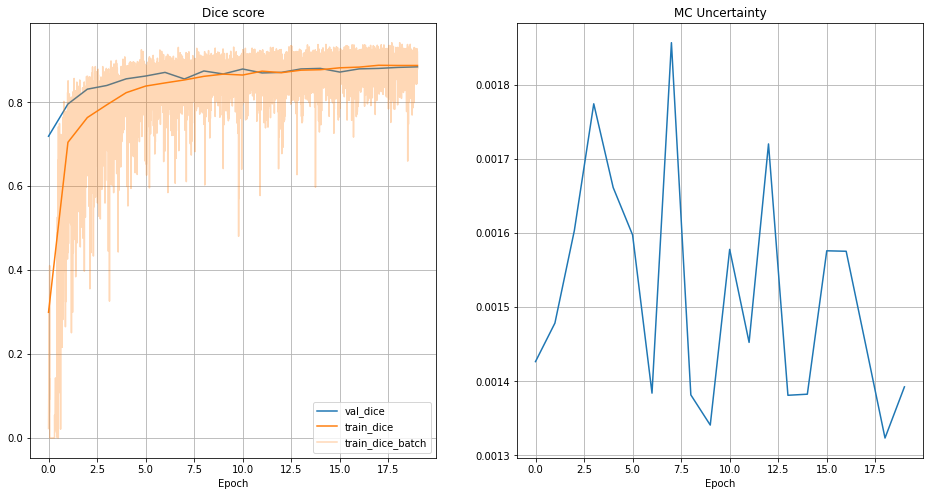

In [11]:
from tqdm import tqdm
n_epochs = 20
prev_dice_score = 0
prev_unc = 0
plot_validating_dice = []
plot_training_dice = []
plot_validating_unc = []
best_dice_score = 0
batches_seen = 0
training_loss = []
n_batches = len(gen_train)
for epoch in range(n_epochs):
    validating_loss = []
    validating_unc = []
    pbar = tqdm(total=len(gen_train), desc=f'Train Epoch {epoch + 1:3d}/{n_epochs:3d}')
    for idx, (inputs, mask) in enumerate(gen_train): # Add the additional inputs inside the brackets
        pbar.update(1)
        h = generator.train_on_batch(inputs, mask)
        training_loss.append(h[-1])
        batches_seen += 1
    pbar.close()
    plot_training_dice.append(np.mean(training_loss[n_batches*epoch:n_batches*(epoch+1)]))
    pbar = tqdm(total=len(gen_val), desc='Val Epoch %d/%d' % (epoch + 1, n_epochs))
    for idx, (inputs, mask) in enumerate(gen_val): # Add the additional inputs inside the brackets
        pbar.update(1)
        validating_loss.append(generator.test_on_batch(inputs, mask)[1])
        validating_unc.append(np.mean(generator_MCunc.predict(inputs).numpy()))
    pbar.close()
    plot_validating_dice.append(np.mean(validating_loss))
    plot_validating_unc.append(np.mean(validating_unc))
    
    val_dice = np.mean(validating_loss)
    val_unc = np.mean(validating_unc)
    diff_dice = val_dice - prev_dice_score
    diff_unc = val_unc - prev_unc
    prev_dice_score = val_dice
    prev_unc = val_unc
    if val_dice > best_dice_score:
        best_dice_score = val_dice
        path = os.path.join(checkpoint_path, f"best_dice_score")
        generator.save(path)
    if epoch % 5 == 0 or epoch == n_epochs - 1:
        path = os.path.join(checkpoint_path, f"epoch_{epoch}")
        generator.save(path)
    clear_output(wait=True)
    print(f"Epoch {epoch+1}, Dice score: {val_dice:.4f}. Diff: {diff_dice:.4f}")
    print(f"Epoch {epoch+1}, validation uncertainty: {val_unc:.4f}. Diff: {diff_unc:.4f}")
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_validating_dice, label="val_dice")
    axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_training_dice, label="train_dice",color='C1')
    axs[0].plot(np.linspace(0, epoch, batches_seen), training_loss, label="train_dice_batch", alpha=0.3, color='C1')
    axs[0].legend()
    axs[1].plot(np.linspace(0, epoch, epoch + 1), plot_validating_unc, label="val_unc")
    axs[0].set_title("Dice score")
    axs[0].grid(True)
    axs[0].set_xlabel('Epoch')
    axs[1].set_title("MC Uncertainty")
    axs[1].grid(True)
    axs[1].set_xlabel('Epoch')
    # Second Row - Display some predictions
    plt.show()
    
    # if (np.mean(validating_loss) < 0.015):
    #     break

## Using the best model on based on validation data.
During training the best model in terms of **dice score** on the validation data is saved. This model is now loaded and used to evaluate on the test data. As well as visualizing the predictions made on different parts of the data.

In [12]:
from keras.models import load_model
model:Model = load_model(os.path.join(checkpoint_path, "best_dice_score"),custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss},compile=False)
model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])
generator_MCunc.f = model

### Train and validation loss and dice score

In [13]:
results_train = model.evaluate(gen_train,return_dict=True)
results_val = model.evaluate(gen_val,return_dict=True)
def print_results(results:dict, name):
    print(f"{name} Dice score: {results['dice_coef']:.4f}")
    print(f"{name} loss: {results['loss']:.4f}")
print_results(results_train, "Train")
print_results(results_val, "Val")

/tmp/ipykernel_11578/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


62/62 [==============================] - 8s 131ms/step - loss: 0.1157 - dice_coef: 0.8843
Train Dice score: 0.9000
Train loss: 0.1000
Val Dice score: 0.8843
Val loss: 0.1157


In [14]:
# n_epochs = 3
# from tqdm import tqdm
# plot_validating_loss = []
# plot_validating_unc = []
# for epoch in range(n_epochs):
#     training_loss = []
#     validating_loss = []
#     validating_unc = []
#     pbar = tqdm(total=len(gen_train), desc=f"Epoch Training {epoch + 1}/{n_epochs}", position=0, leave=True)
#     for idx, (inputs, mask) in enumerate(gen_train): # Add the additional inputs inside the brackets
#         pbar.update(1)
#         h = generator.train_on_batch(inputs, mask)
#         training_loss.append(h)
#     pbar = tqdm(total=len(gen_val), desc=f"Epoch Validation {epoch + 1}/{n_epochs}", position=1, leave=True)    
#     for idx, (inputs, mask) in enumerate(gen_val): # Add the additional inputs inside the brackets
#         pbar.update(1)
#         validating_loss.append(generator.test_on_batch(inputs, mask)[1])
#         validating_unc.append(np.mean(generator_MCunc.predict(inputs).numpy()))
    
#     plot_validating_loss.append(np.mean(validating_loss))
#     plot_validating_unc.append(np.mean(validating_unc))
        
#     print(np.mean(validating_loss))
#     print(np.mean(validating_unc))
        

    
#     clear_output(wait=True)
#     print("Epoch " + str(epoch) + ", validation loss: " + str(np.mean(validating_loss))[:6])
#     fig, axs = plt.subplots(1, 2, figsize=(16,8))
#     axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_validating_loss, label="val_loss")
#     axs[1].plot(np.linspace(0, epoch, epoch + 1), plot_validating_unc, label="val_unc")
#     axs[0].set_title("Validation loss")
#     axs[0].grid(True)
#     axs[0].set_xlabel('Epoch')
#     axs[1].set_title("MC Uncertainty")
#     axs[1].grid(True)
#     axs[1].set_xlabel('Epoch')
#     plt.show()
    
#     # if (np.mean(validating_loss) < 0.015):
#     #     break

# # NOTE: When should training stop? How long did it take to reach the required DICE score?
# # NOTE: Describe what behavior you expect from the two plots?
# # NOTE: Detail what outcomes you have faced when the training failed? Why do you think that happened? How did you try to fix it?

In [15]:
def threshold_uncertainty(uncertainty:np.ndarray, threshold:float):
    return np.where(uncertainty > threshold, 1, 0)
def threshold(prediction:np.ndarray, threshold:float=0.5):
    return np.where(prediction > threshold, 1, 0)

1/1 [==============================] - 0s 158ms/step


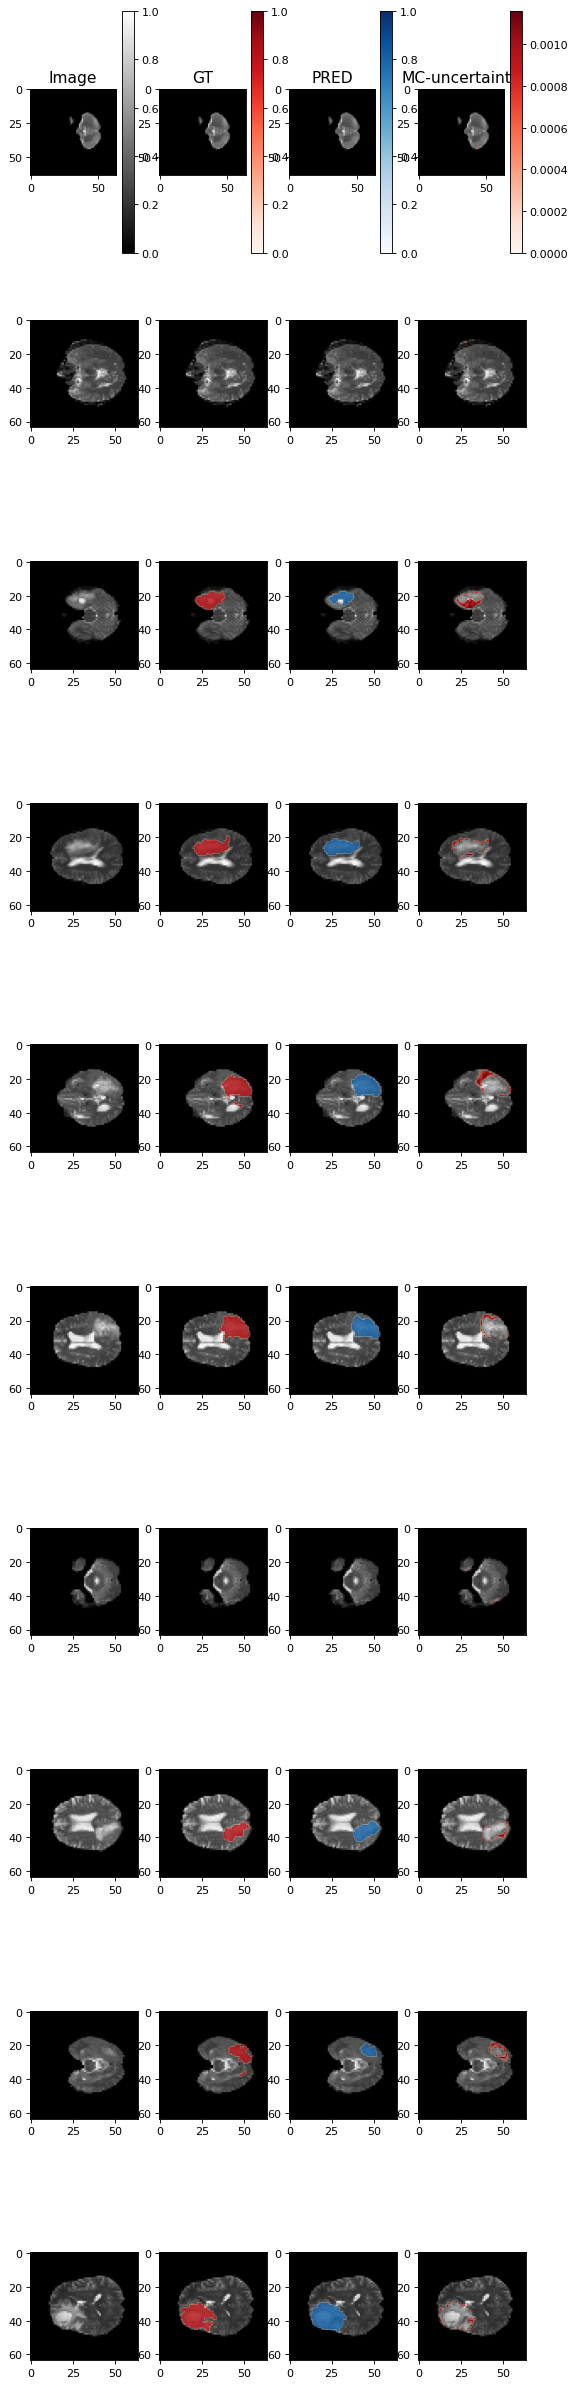

In [16]:
%matplotlib inline
inputs, mask = gen_val[np.random.randint(0, len(gen_val))] # Add the additional inputs
prediction = model.predict([inputs])
uncertainty = generator_MCunc.predict([inputs], n_iter=100)
n_figs = 10
font_size = 14
plt.figure(figsize=(8, 4 * n_figs),dpi=80)
for idx in range(n_figs):
    x = inputs[idx, :, :,-2]
    y = mask[idx, :, :]
    pred = (threshold(prediction[idx, :, :])).astype(np.float32)
    unc = uncertainty[idx, :, :]
    alphas_label = np.ma.masked_array(y, mask=y>=0)
    alphas_label = np.where(alphas_label, 0.8, 0).astype(np.float32).squeeze()
    alphas_pred = np.ma.masked_array(pred, mask=pred>=0)
    alphas_pred = np.where(alphas_pred, 0.8, 0).astype(np.float32).squeeze()
    
    alphas_unc = np.array(unc).squeeze()/np.max(unc)# np.ma.masked_array(unc, mask=unc>=1e-2)
    plt.subplot(n_figs, 4, idx * 4 + 1)
    plt.imshow(x, cmap='gray', vmin=0, vmax=1)
    if idx == 0:
        plt.colorbar()
        plt.title('Image', fontsize=font_size)
    plt.subplot(n_figs, 4, idx * 4 + 2)
    plt.imshow(x, cmap='gray', vmin=0, vmax=1)
    plt.imshow(alphas_label, cmap='Reds', vmin=0, vmax=1, alpha=alphas_label)
    if idx == 0:
        plt.colorbar()
        plt.title('GT', fontsize=font_size)
    plt.subplot(n_figs, 4, idx * 4 + 3)
    # plt.imshow(, cmap='gray', vmin=0, vmax=1)
    plt.imshow(x, cmap='gray', vmin=0, vmax=1)
    plt.imshow(alphas_pred, cmap='Blues', vmin=0, vmax=1, alpha=alphas_pred)
    if idx == 0:
        plt.colorbar()
        plt.title('PRED', fontsize=font_size)
    plt.subplot(n_figs, 4, idx * 4 + 4)
    plt.imshow(x, cmap='gray', vmin=0, vmax=1)
    # plt.imshow(alphas_pred, cmap='Blues', vmin=0, vmax=1, alpha=alphas_pred/2)
    plt.imshow(unc, cmap='Reds', vmin=0, vmax=np.max(unc), alpha=alphas_unc)
    if idx == 0:
        plt.colorbar()
        plt.title('MC-uncertainty', fontsize=font_size)
# Decrease vertical spacing between subplots
plt.subplots_adjust(hspace=0.0)
# NOTE: How good do the images look like? What do you think is needed for better results?
# NOTE: Discuss the difference between false positives and false negatives in the segmentations.
# NOTE: Discuss the uncertainties. Where is it large, where is it small? Why? Is this what you would expect?

From the images above one can clearly see the model is able to segment the tumors successfully and that the models uncertainty lies at the border of segmentation. This is expected as the edges of a tumor is not a discrete cutoff but rather a gradual change. The Monte Carlo Dropout model captures this emp 

/tmp/ipykernel_11578/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


(array([349.,   4.,   2.,   1.,   3.,   2.,   4.,  13.,  57., 557.]),
 array([2.06001602e-07, 4.89899814e-02, 9.79797617e-02, 1.46969527e-01,
        1.95959315e-01, 2.44949088e-01, 2.93938875e-01, 3.42928648e-01,
        3.91918421e-01, 4.40908194e-01, 4.89897966e-01]),
 <BarContainer object of 10 artists>)

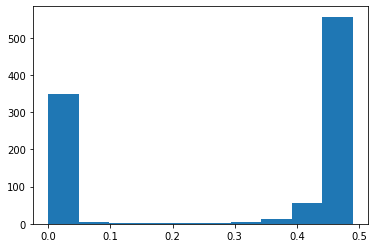

In [17]:
testing_loss = []
for idx, (inputs, mask) in enumerate(gen_test): # Add the additional inputs inside the brackets
    mn = np.max(generator_MCunc.predict([inputs]), axis=(1, 2, 3))
    testing_loss.extend(mn)
plt.hist(testing_loss)

# NOTE: Only evaluate the testing set, when you are not changing the code anymore.
# NOTE: How different is the performance on the validation and testing sets?
# NOTE: Do your results speak of overfitting? Underfitting?
# NOTE: This code evaluates the uncertainty maps. 
# NOTE: Explore the histogram, and investigate why some data samples might have larger uncertainties

In [27]:
results_test = model.evaluate(gen_test,return_dict=True)
print_results(results_test, "Test")

/tmp/ipykernel_11578/3735593649.py:63: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


62/62 [==============================] - 8s 128ms/step - loss: 0.2353 - dice_coef: 0.7647
Test Dice score: 0.7647
Test loss: 0.2353


## Results Dice
After training the model for $20$ epochs with a batch size of $16$ on a Nvidia 3060 Ti GPU the following results were achieved:
| Dataset | Dice score |
| --- | --- |
| Training | $0.900$ |
| Validation | $0.884$ |
| Test | $0.765$ |


The results indicate that the model is able to generalize well to unseen data. However, the test score is significantly lower than the validation score. This is not expected since the model was not trained on the validation data. These sort of sceewed result is usually due to either overfitting of the validation data through hyperparameter tuning or different distributions of the training/validation data and the test data, this will be explored further in the next section.

## Analysis of the results and dataset distributions
To describe the results further the following code was used to investigate the distributions of the various datasets.

In [19]:
def extract_data(data:DataGenerator):
    """Stack all the data in a single array"""
    all_inputs = []
    all_masks = []
    for idx, (inputs, mask) in tqdm(enumerate(data), desc=f"Extracting {data.data_path}"): # Add the additional inputs inside the brackets
        all_inputs.append(inputs)
        all_masks.append(mask)
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    return all_inputs, all_masks
all_train, all_train_masks = extract_data(gen_train)
all_val, all_val_masks = extract_data(gen_val)
all_test, all_test_masks = extract_data(gen_test)

Extracting ./data/training: 500it [01:07,  7.36it/s]
Extracting ./data/validating: 62it [00:09,  6.70it/s]
Extracting ./data/testing: 62it [00:08,  7.61it/s]


In [20]:
def analysis_dataset(all_data:np.ndarray, all_masks:np.ndarray, title:str):
    mean_data_img = np.mean(all_train, axis=(0))
    n_channels = mean_data_img.shape[-1]
    mean_masks_img = np.mean(all_masks, axis=(0))
    mean_data = np.mean(all_train, axis=(0, 1, 2))
    mean_mask = float(np.mean(all_masks, axis=(0, 1, 2)))
    std_data_img = np.std(all_train, axis=(0))
    std_masks_img = np.std(all_masks, axis=(0))
    std_data = np.std(all_train, axis=(0, 1, 2))
    std_mask = float(np.std(all_masks, axis=(0, 1, 2)))

    print(f"Mean {title} inputs:")
    for channel in range(n_channels):
        print(f"Channel {channel}: {mean_data[channel]:.2e} +- {std_data[channel]:.2e}")
    print(f"Mean of {title} mask: {mean_mask:.2e} +- {std_mask:.2e}")
    return mean_data_img, mean_masks_img, std_data_img, std_masks_img

In [21]:
mean_train_data_img, mean_train_masks_img, std_train_data_img, std_train_masks_img = analysis_dataset(all_train, all_train_masks, "training")
mean_val_data_img, mean_val_masks_img, std_val_data_img, std_val_masks_img = analysis_dataset(all_val, all_val_masks, "validation")
mean_test_data_img, mean_test_masks_img, std_test_data_img, std_test_masks_img = analysis_dataset(all_test, all_test_masks, "testing")


Mean training inputs:
Channel 0: 1.39e-01 +- 2.50e-01
Channel 1: 8.34e-02 +- 1.57e-01
Channel 2: 8.42e-02 +- 1.59e-01
Channel 3: 1.02e-01 +- 1.93e-01
Mean of training mask: 1.68e-02 +- 1.28e-01
Mean validation inputs:
Channel 0: 1.39e-01 +- 2.50e-01
Channel 1: 8.34e-02 +- 1.57e-01
Channel 2: 8.42e-02 +- 1.59e-01
Channel 3: 1.02e-01 +- 1.93e-01
Mean of validation mask: 2.10e-02 +- 1.43e-01
Mean testing inputs:
Channel 0: 1.39e-01 +- 2.50e-01
Channel 1: 8.34e-02 +- 1.57e-01
Channel 2: 8.42e-02 +- 1.59e-01
Channel 3: 1.02e-01 +- 1.93e-01
Mean of testing mask: 1.48e-02 +- 1.21e-01


### Plot of the mean and standard deviation of the datasets' pixel values

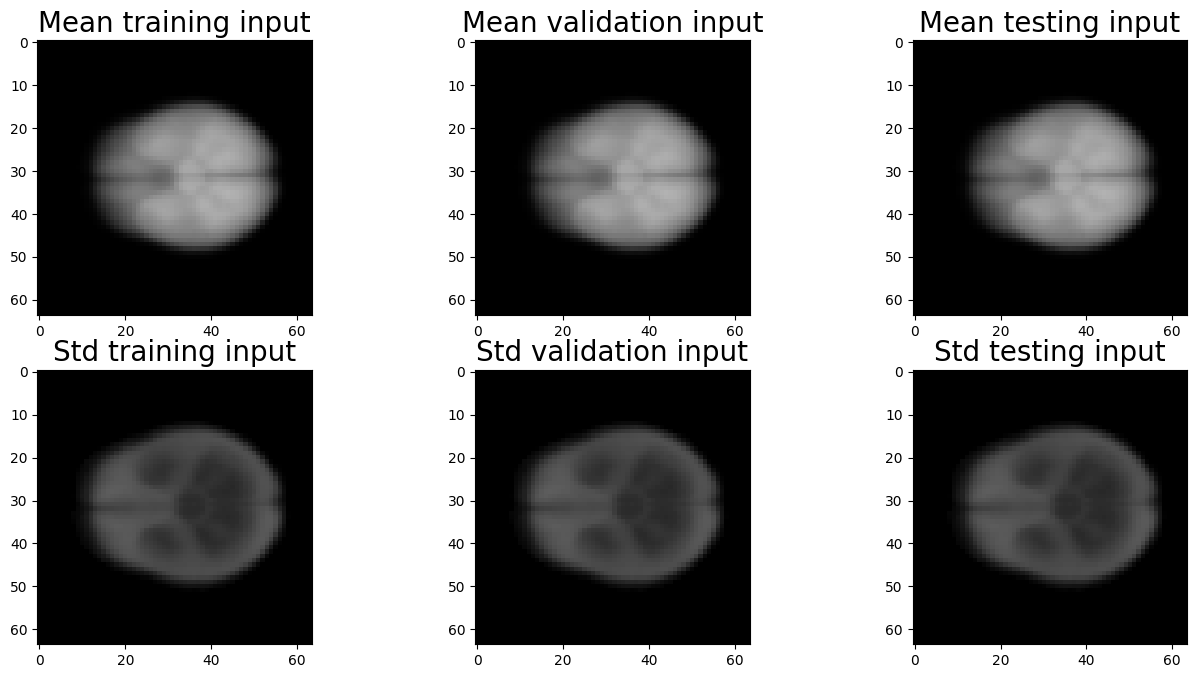

In [22]:
fig,axs = plt.subplots(2,3,figsize=(16,8),dpi=100)
axs[0,0].imshow(mean_train_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,0].set_title('Mean training input',fontsize=20)
axs[0,1].imshow(mean_val_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,1].set_title('Mean validation input',fontsize=20)
axs[0,2].imshow(mean_test_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,2].set_title('Mean testing input',fontsize=20)
axs[1,0].imshow(std_train_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,0].set_title('Std training input',fontsize=20)
axs[1,1].imshow(std_val_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,1].set_title('Std validation input',fontsize=20)
axs[1,2].imshow(std_test_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,2].set_title('Std testing input',fontsize=20)
plt.show()

### Visualization of the mean and standard deviation of the datasets' mask pixel values

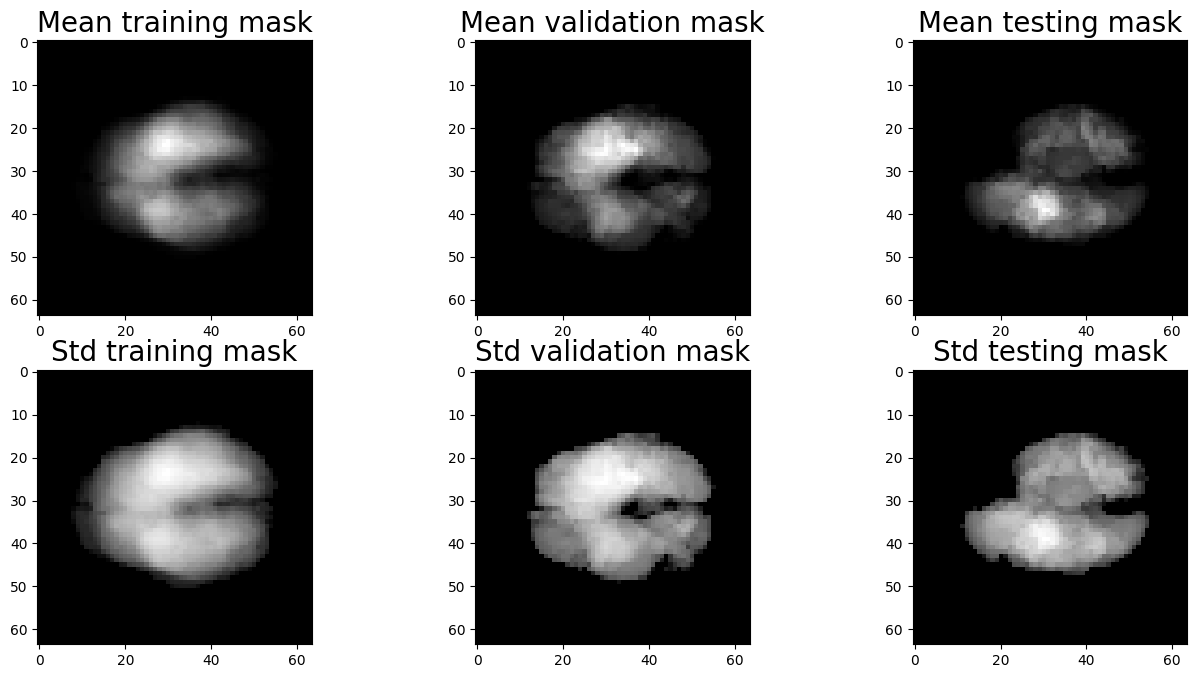

In [23]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))
fig,axs = plt.subplots(2,3,figsize=(16,8),dpi=100)
axs[0,0].imshow(normalize(mean_train_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,0].set_title('Mean training mask',fontsize=20)
axs[0,1].imshow(normalize(mean_val_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,1].set_title('Mean validation mask',fontsize=20)
axs[0,2].imshow(normalize(mean_test_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,2].set_title('Mean testing mask',fontsize=20)
axs[1,0].imshow(normalize(std_train_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,0].set_title('Std training mask',fontsize=20)
axs[1,1].imshow(normalize(std_val_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,1].set_title('Std validation mask',fontsize=20)
axs[1,2].imshow(normalize(std_test_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,2].set_title('Std testing mask',fontsize=20)
plt.show()


## Dataset distributions analysis
From the figures above one can clearly see the that all inputs are very similar, (atleast the expected input). The visualization of the expected masks might show the reason of the discrepeancy between the **dice scores** on the train/validation sets and the test set.

The test set seems like it does not include many tumors in the $2^{\text{nd}}$ quadrant. This might be due to some sort of corruption in the data handeling process or simly a results of random splitting when seperating the data into train/validation/test sets.

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_samples(data_inputs:np.ndarray,data_masks:np.ndarray, n:int=10, model:Model=None, unc_model:MonteCarloDropoutModel=None, title:str=None):
    indexes = np.random.randint(0, len(data_inputs), n)
    rows = np.sqrt(n).astype(int)
    cols = np.ceil(n/rows).astype(int)
    fig = plt.figure(figsize=(20, 20), dpi=100)
    per_input = (1 + (model is not None) + (unc_model is not None))
    cols = per_input if per_input > 1 else cols
    grid = ImageGrid(fig, 111, nrows_ncols=(rows*per_input, cols), axes_pad=0.0)
    first_row = True
    for i, idx in zip(range(0,len(grid),per_input), indexes):
        
        x = data_inputs[idx, :, :]
        y = data_masks[idx, :, :]
        alphas_label = np.ma.masked_array(y, mask=y>=0)
        alphas_label = np.where(alphas_label, 0.8, 0).astype(np.float32).squeeze()
        grid[i].imshow(x[...,-2], cmap='gray', vmin=0, vmax=1)
        grid[i].imshow(alphas_label, cmap='Reds', vmin=0, vmax=1, alpha=alphas_label)
        grid[i].axis('off')
        if model: # Plot predictions
            i = i+1
            y_pred = threshold(model.predict(x[np.newaxis, ...], verbose=0)[0])
            alphas_pred = np.ma.masked_array(y_pred, mask=y>=0)
            alphas_pred = np.where(alphas_pred, 0.8, 0).astype(np.float32).squeeze()
            grid[i].imshow(x[...,-2], cmap='gray', vmin=0, vmax=1)
            grid[i].imshow(alphas_pred, cmap='Blues', vmin=0, vmax=1, alpha=alphas_pred)
            grid[i].axis('off')
        if unc_model: # Plot uncertainty
            i = i+1
            unc = unc_model.predict(x[np.newaxis, ...])[0]
            alphas_unc = np.array(unc).squeeze()/np.max(unc)# np.ma.masked_array(unc, mask=unc>=1e-2)
            grid[i].imshow(x[...,-2], cmap='gray', vmin=0, vmax=1)
            grid[i].imshow(alphas_unc, cmap='Greens', vmin=0, vmax=1, alpha=alphas_unc)
            grid[i].axis('off')
    if model or unc_model:
        # Increase spacing between grid elements
        if first_row:
            grid[0].set_title('Input', fontsize=20)
            if model:
                grid[1].set_title('Prediction', fontsize=20)
            if unc_model:
                grid[2].set_title('Uncertainty', fontsize=20)
            first_row = False
    if title:
        fig.suptitle(title, fontsize=20)
    plt.show()        

## Visual inspection of the test set vs the validation set

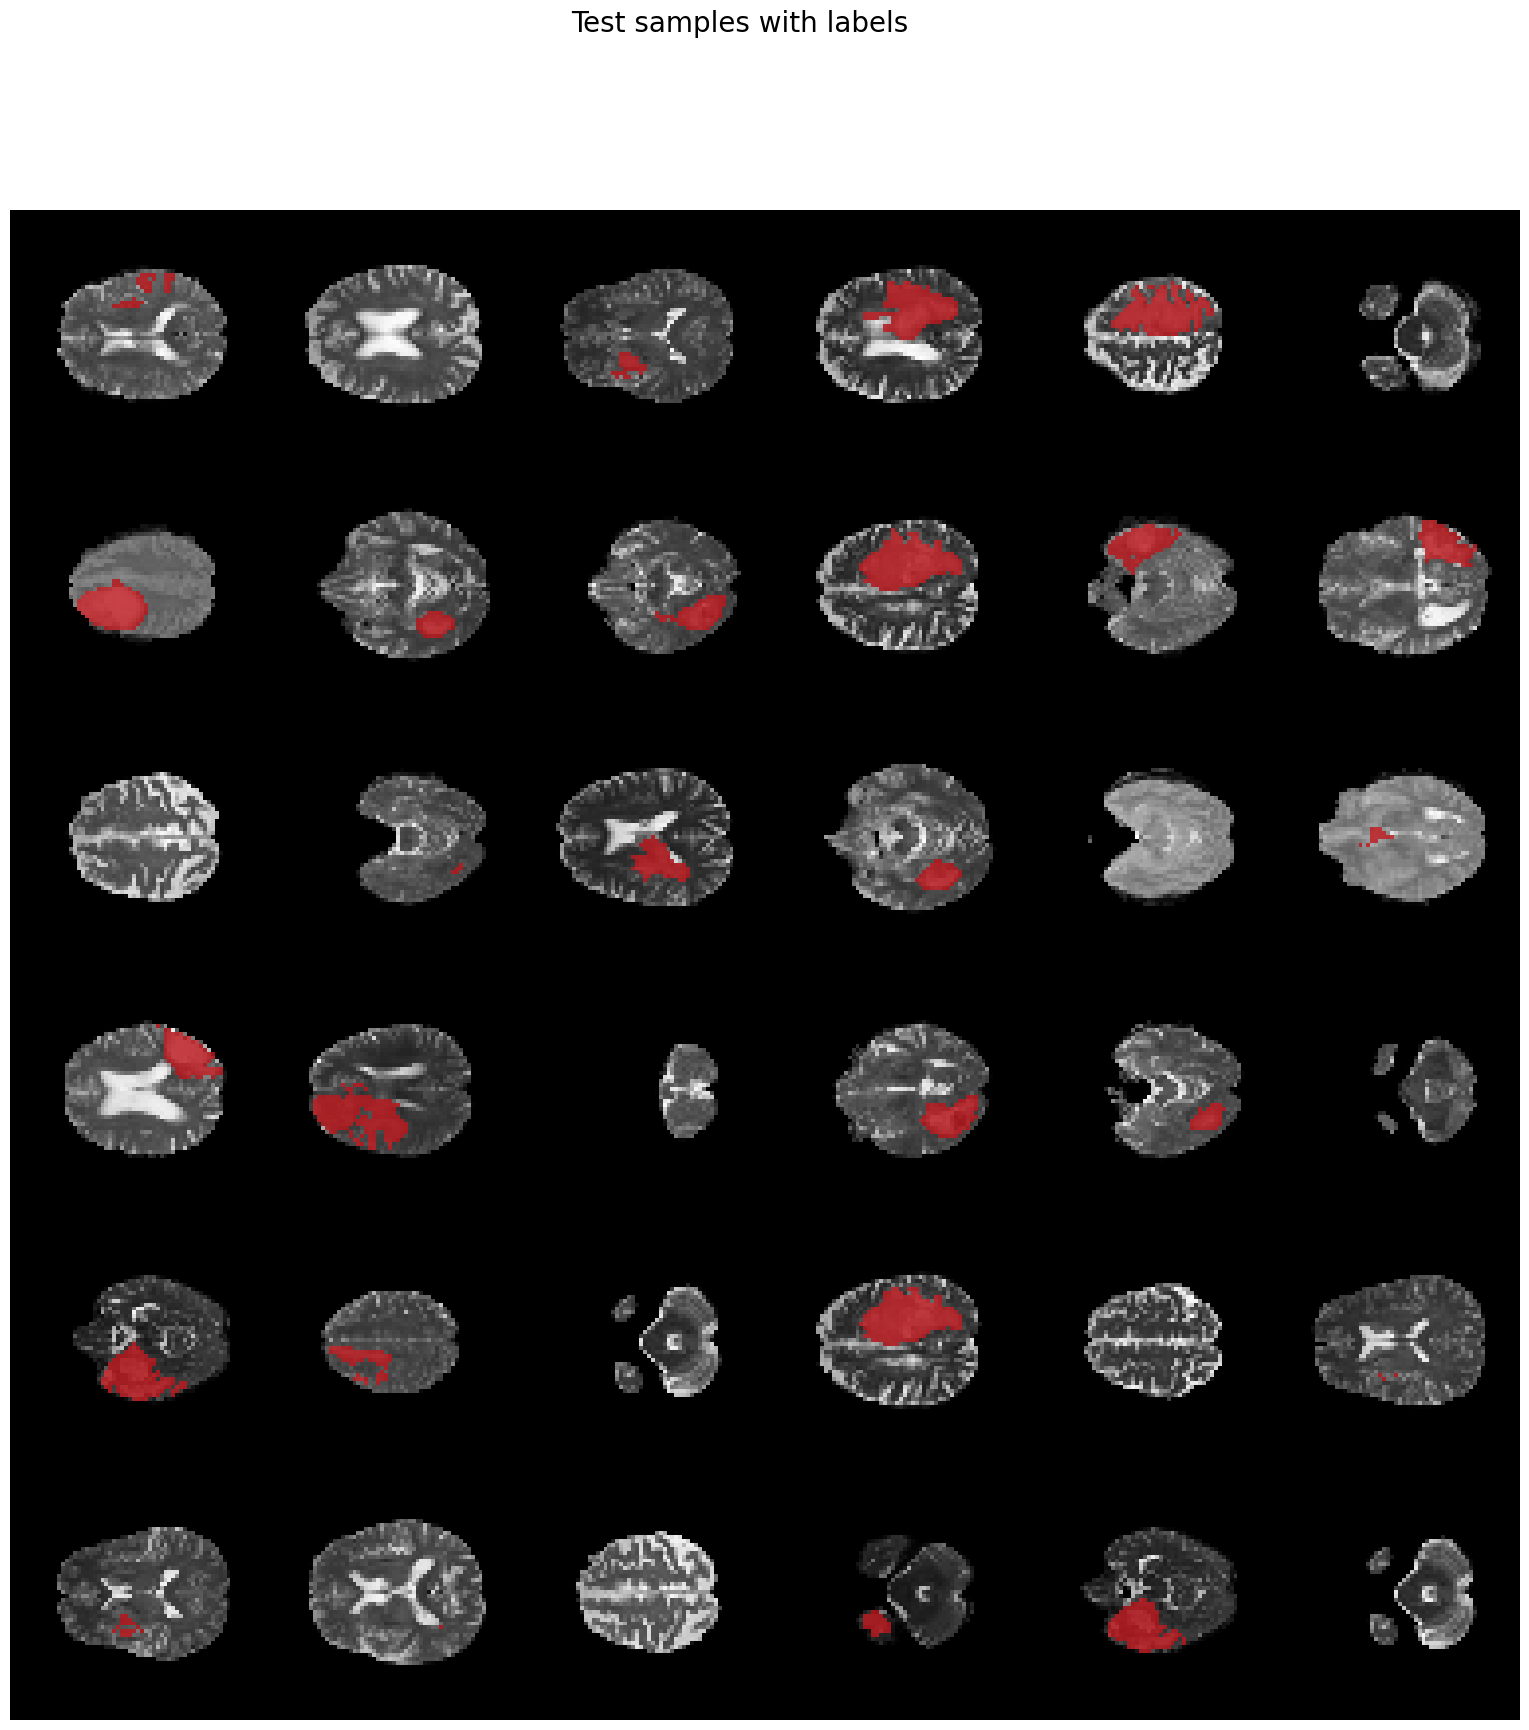

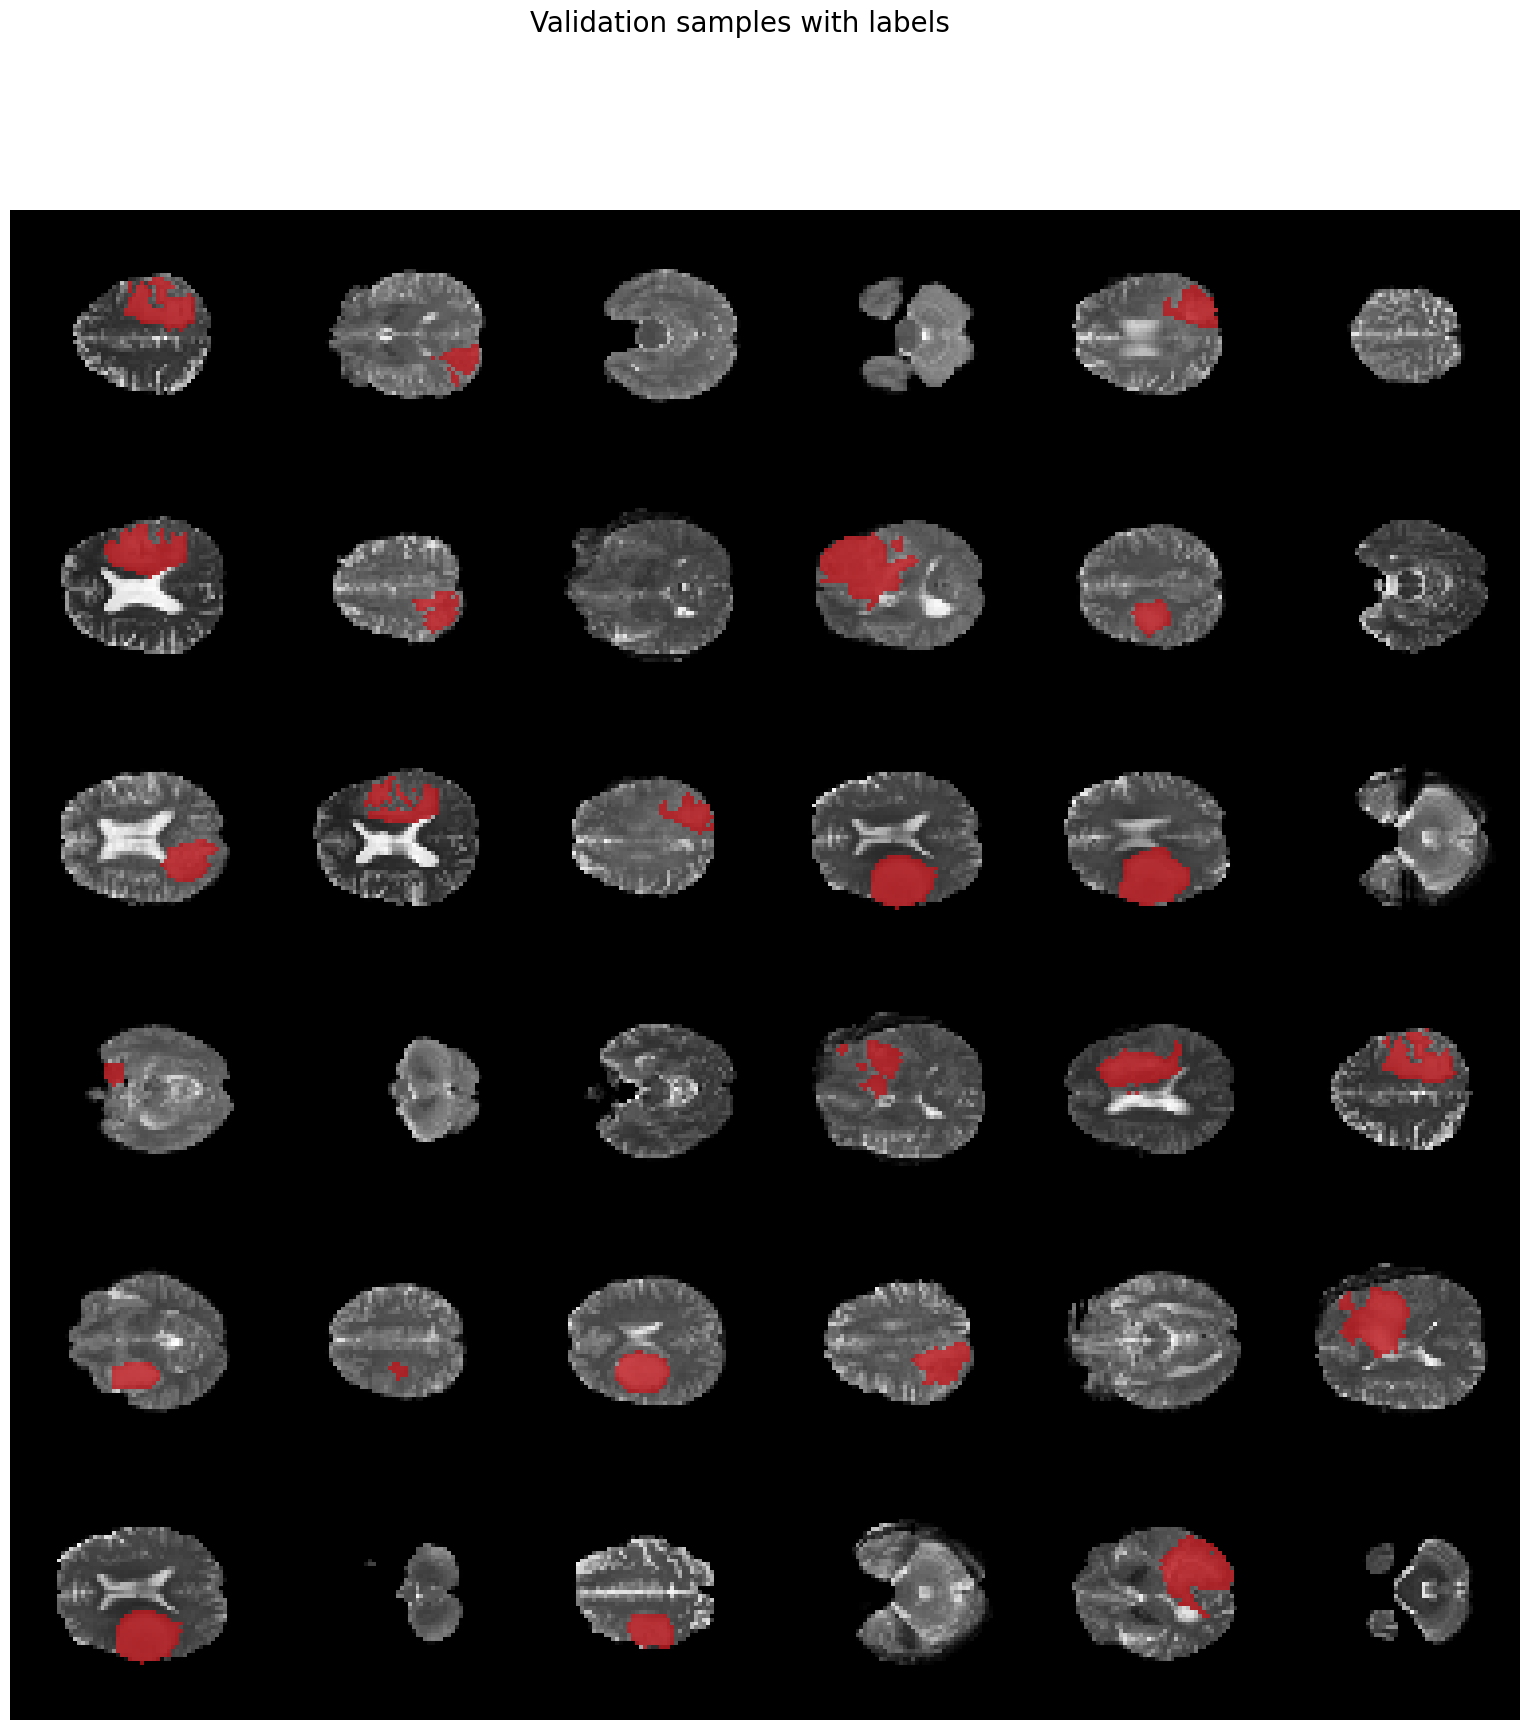

In [25]:
n_samples = 36
plot_samples(all_test, all_test_masks, n_samples, title="Test samples with labels")
plot_samples(all_val, all_val_masks, n_samples, title="Validation samples with labels")

Using the randomly selected image from the test and validation set one can see that there is not occurrence of large tumors in the $2^{\text{nd}}$ quadrant of the test set. This is not the case for the validation set. Here we find that like the mean and standard deviation of the pixel values suggest there is an more even distribution of the tumors in the validation set. It shall be noted that this is only a small subset of the data. However, it is likely that the test set is not representative of the validation set and therefore the model is not able to generalize well to the test set or at least not perform as well on the entire test set as it does on the validation set.

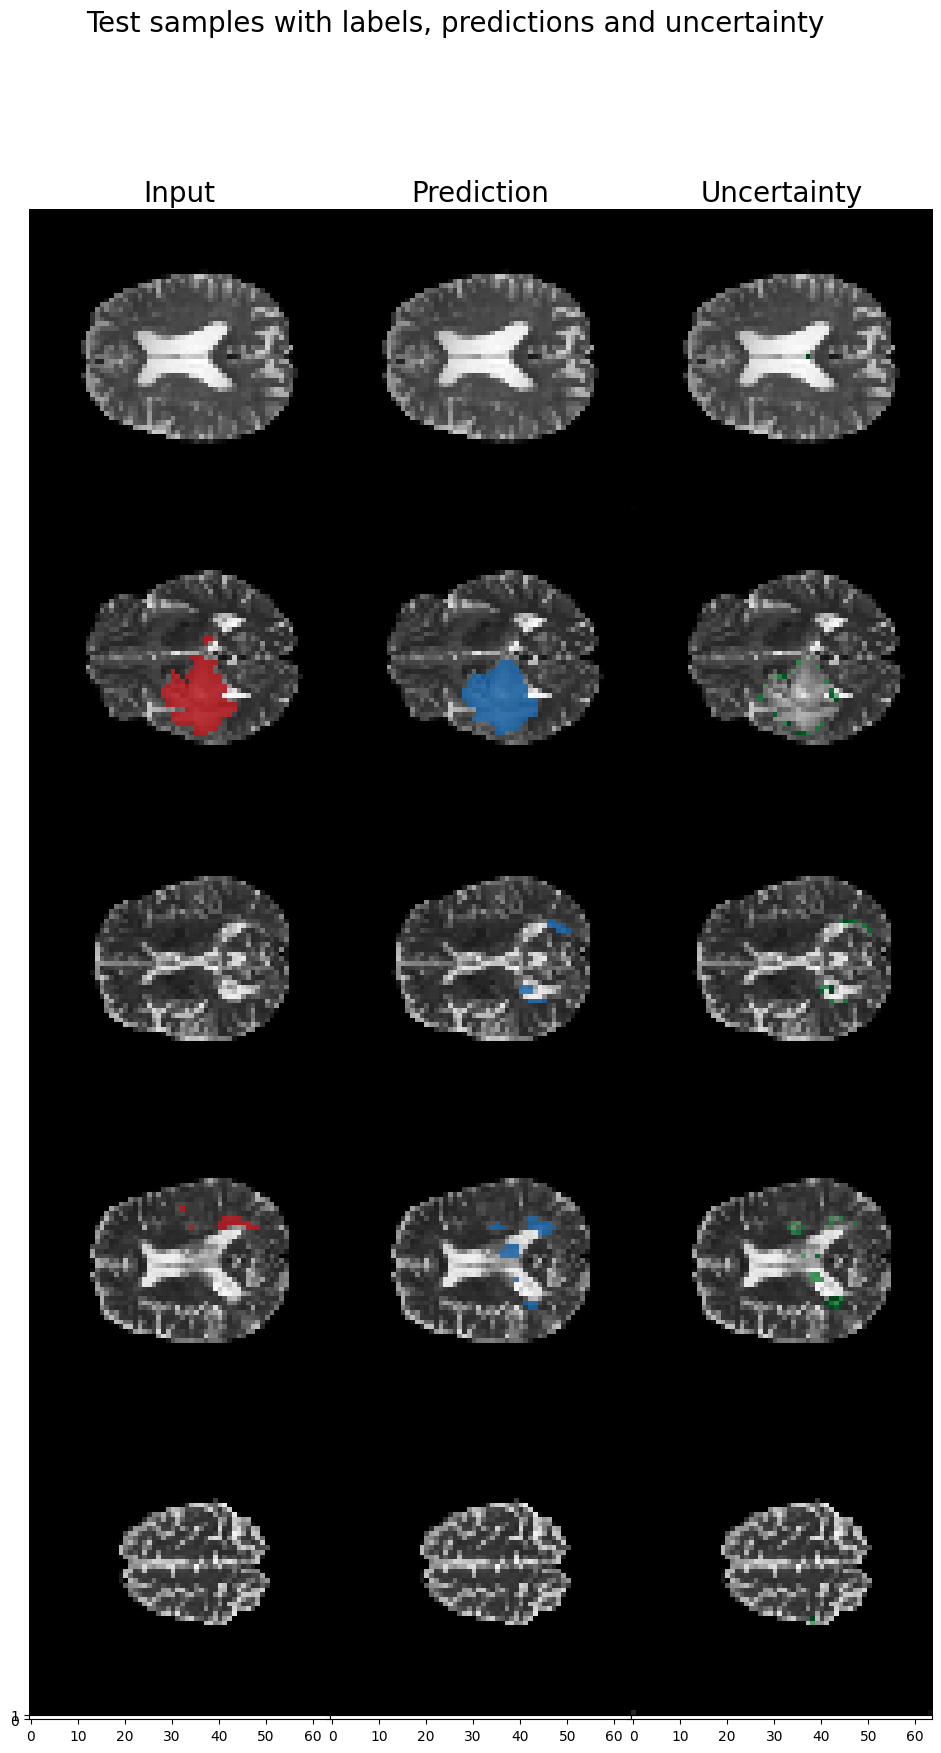

In [26]:
plot_samples(all_test, all_test_masks, 5, model=model, unc_model=generator_MCunc, title="Test samples with labels, predictions and uncertainty")